In [82]:
#importing necessary libraries
import numpy as np
import pandas as pd   
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import norm

In [2]:
#scalars used 
cg = 1.78
eps = 1e-2
laplace_scale = 1.0 / (2**.5)

In [3]:
#setting seed
np.random.seed(50)

In [4]:
2*((2*cg)**.5)**2

7.12

## Helper Functions

In [5]:
def random_generator(n,a,gamma=(2*cg)**.5):
    """Draws n random numbers from normal, laplace and 
    cauchy distributions with parameter a"""
    distributions = {}
    distributions['normal'] = a + np.random.randn(n)
    distributions['laplace'] = a + np.random.laplace(size = n,scale = laplace_scale)
    distributions['cauchy'] = a + scipy.stats.cauchy.rvs(size=n,loc = 0, scale = gamma)
    return distributions

def cauchy_likelihood(data, gamma, a):
    """Likelihood function of cauchy distribution"""
    return -np.sum(np.log(1 + ((data-a)/gamma)**2))

def f(data,gamma,a):
    """Optimization function for the cauchy distribution (given gamma)."""
    return np.sum((a-data)/(1 + ((data-a)/gamma)**2))

def df_da(data,gamma,a):
    """derivative of f with respect to a."""
    return np.sum((1 - ((data-a)/gamma)**2)/((1 + ((data-a)/gamma)**2)**2))

def nr(data,guess,gamma,iterations=1000):
    """Newton-Raphson method for estimating the location parameter of a Cauchy distribution."""
    for iteration in range(iterations):
        y = f(data,gamma, guess)
        dy_dA = df_da(data, gamma, guess)
        guess -= y/dy_dA
        if abs(y) < eps:
            break
    return guess

def grad_desc(data,guess,gamma,iterations=1000):
    """gradient descent method for estimating the location parameter of a cauchy distribution."""
    lr = 1e-3
    pguess = 1e5
    for _ in range(iterations):
        y = f(data,gamma, guess)
        pguess = guess
        guess -= lr*y
        if abs(pguess-guess) < eps:
            break
    return guess

def mle_estimates(distributions, gamma, guess):
    """Calculates the mle estimates for normal, laplace and cauchy distributions."""
    estimates = {}
    for key in distributions.keys():
        if key == 'normal':
            estimates[key] = np.mean(distributions[key])
        elif key == 'laplace':
            estimates[key] = np.median(distributions[key])
        elif key == 'cauchy':
            estimates[key] = nr(distributions[key], guess, gamma=gamma,iterations=10000)
    return estimates

def Fisher_information(n):
    """Calculates the fisher information for the cauchy distribution."""
    return {"normal" : n, "laplace": n/2,  "cauchy": n/4*cg } # "cauchy": 1/(2*gamma**2)

## Experiments

In [6]:
# from tqdm import tqdm

def realisations(n, a, num_realisations):
    """Generates n random numbers and calculates MLE estimates for num_realisations."""
    estimates = {"normal": [], "laplace": [], "cauchy": []}
    
    for _ in tqdm(
        range(num_realisations),
        desc=f"n={n} | Realisations",
        leave=False,
        dynamic_ncols=True,
    ):
        distributions = random_generator(n, a)
        estimate = mle_estimates(distributions, gamma=(2 * cg) ** 0.5, guess=np.median(distributions["cauchy"]))


        for key in estimate:
            estimates[key].append(estimate[key])
    
    return estimates

def get_statistics(estimates):
    """Calculates mean and standard deviation of MLE estimates."""
    statistics = {}
    for key in estimates:
        statistics[key] = {
            'mean': np.mean(estimates[key]),
            'var': np.var(estimates[key])
        }
    return statistics

def iter_over_sample_size(ns, a, num_realisations):
    """Iterates over different sample sizes and calculates MLE estimates."""
    estimates = {}
    stats = {}

    outer = tqdm(ns, desc="Sample Sizes", dynamic_ncols=True)
    for n in outer:
        outer.set_description(f"Sample size: n={n}")
        estimates[n] = realisations(n, a, num_realisations)
        stats[n] = get_statistics(estimates[n])
        outer.write(f"Done: n={n}, num_real={num_realisations}")
    
    return estimates, stats

def give_results(a, sample_sizes, num_realisations):
    data = {}
    for ni in sample_sizes:
        data[f"{ni}"]={}
        for nri in num_realisations:
            data[f"{ni}"][f"normal_{nri}"]={}
            data[f"{ni}"][f"laplace_{nri}"]={}
            data[f"{ni}"][f"cauchy_{nri}"]={}
            
    for nr in num_realisations:
        estimates, stats = iter_over_sample_size(sample_sizes, a, nr)
        for ni in sample_sizes:
            data[f"{ni}"][f"normal_{nr}"] = rf'{stats[ni]["normal"]["mean"]:.3f} ± {np.sqrt(stats[ni]["normal"]["var"]):.3f}'
            data[f"{ni}"][f"laplace_{nr}"] = rf'{stats[ni]["laplace"]["mean"]:.3f} ± {np.sqrt(stats[ni]["laplace"]["var"]):.3f}'
            data[f"{ni}"][f"cauchy_{nr}"] = rf'{stats[ni]["normal"]["mean"]:.3f} ± {np.sqrt(stats[ni]["cauchy"]["var"]):.3f}'
    df = pd.DataFrame(data).T
    ordered_cols = [f"normal_{nr}" for nr in num_realisations]
    ordered_cols.extend([f"laplace_{nr}" for nr in num_realisations])
    ordered_cols.extend([f"cauchy_{nr}" for nr in num_realisations])
    df = df.loc[:,ordered_cols]
    return df, estimates, stats


## Plotting functions

In [135]:
def plot_cdf(a, data, stat ,label='CDF', color='blue', axis=None):
    """Plots the CDF of the data."""
    if axis is None:
        _, axis = plt.subplots(figsize=(5, 5), layout="constrained")
    sorted_data = np.sort(data)
    cdf = np.linspace(0, 1, len(sorted_data))
    axis.step(sorted_data, cdf, where='post', label=label, color=color)
    axis.set_xlabel(r'Value of $\hat{a}$')
    axis.set_ylabel('Cum. Probability')
    axis.set_title(f"CDF of {label} distribution")
    # axis.set_title(rf"CDF of {label} with mean: {stat['mean']:.3E}, var: {stat['var']:.3E}, I$^{{-1}} = $ {1/I[label]:.3E}")
    axis.set_xlim(max(-3+a,np.min(data)), min(3+a,np.max(data)))

def plot_cdf_pdf(ns, a, estimates, stats):
    for n in ns:
        # Create main figure with constrained layout
        fig = plt.figure(figsize=(10, 6), constrained_layout=True)
        fig.suptitle(f"Sample size: {n}", y=1.05, fontsize=14)
        
        # Create 3 subfigures (rows) for each estimator
        subfigs = fig.subfigures(nrows=3, ncols=1)
        
        for i, (key, subfig) in enumerate(zip(estimates[n].keys(), subfigs)):
            # Set row title (subfigure title)
            subfig.suptitle(f"{key} Distribution", fontsize=12, y=1.02)
            
            # Create 1x2 subplots for PDF and CDF
            ax_pdf, ax_cdf = subfig.subplots(nrows=1, ncols=2)
            
            # --- PDF Plot ---
            ax_pdf.set_xlabel(r'Value of $\hat{a}$')
            ax_pdf.set_ylabel('Post. Probability')
            ax_pdf.hist(estimates[n][key], density=True, bins=70, alpha=0.5,
                        color='blue', label='PDF',
                        range=(max(-3+a, np.min(estimates[n][key])),
                               min(3+a, np.max(estimates[n][key]))))
            
            # Add statistics to PDF title
            I = Fisher_information(n)
            pdf_stats = (rf"$\mu$: {stats[n][key]['mean']:.3E}, "
                         rf"$\sigma^2$: {stats[n][key]['var']:.3E}, "
                         rf"$I^{{-1}}$: {1/I[key]:.3E}")
            ax_pdf.set_title(f"PDF of {key}\n{pdf_stats}", fontsize=10, pad=12)
            
            # --- CDF Plot ---
            plot_cdf(a, estimates[n][key], stats[n][key], label=key, color='blue', axis=ax_cdf)
            # Add matching statistics to CDF title
            ax_cdf.set_title(f"CDF of {key}\n{pdf_stats}", fontsize=10, pad=12)
            
        plt.show()

def plot_cdf_I_a(ns, a, estimates, stats):
    fig = plt.figure(figsize=(10, 24), constrained_layout=True)
    fig.suptitle(r"Plot of $\sqrt{N}(\hat{A} - A)$ and $N(0, I(A)^{-1})$", y=1.03, fontsize=16)

    # Create subfigures with extra vertical spacing
    subfigs = fig.subfigures(nrows=len(ns), ncols=1)

    for (n, subfig) in zip(ns, subfigs):
        subfig.suptitle(f"Sample size N = {n}", fontsize=12, y=1.02)
        axs = subfig.subplots(nrows=1, ncols=3)

        I = Fisher_information(n)

        for i, key in enumerate(estimates[n].keys()):
            data = (np.array(estimates[n][key]) - a) * np.sqrt(n)
            plot_cdf(a, data, stats[n][key], label='Numerical CDF', color='blue', axis=axs[i])
            axs[i].set_xlabel(r'Value of $\hat{A}$')
            axs[i].set_ylabel('Cumm. Probability')

            x = np.linspace(max(-3 + a, np.min(data)), min(3 + a, np.max(data)), 500)
            axs[i].plot(x, norm.cdf(x, 0, np.sqrt(n)/np.sqrt(I[key])), 'r-', label='Theo CDF')

            axs[i].set_title(rf'CDF of {key} distribution', fontsize=9, pad=3)
    plt.legend()
    plt.show()

def plot_mean_var(stats):
    _, axs = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
    mean, var = {"normal": [], "laplace": [], "cauchy": []},{"normal": [], "laplace": [], "cauchy": []}
    for n in stats.keys():
        for key in mean.keys():
            mean[key].append(stats[n][key]['mean'])
            var[key].append(stats[n][key]['var'])
    for key in mean.keys():
        axs[0].semilogy(stats.keys(), mean[key], label=key)
        axs[1].semilogy(stats.keys(), var[key], label=key)
    axs[0].set_xlabel(r'Sample Size')
    axs[0].set_ylabel(r'Mean of $\hat{a}$')
    axs[0].set_title(r'Mean of $\hat{a}$')
    # axs[0].set_xscale(r'log')
    axs[1].set_xlabel(r'Sample Size')
    axs[1].set_ylabel(r'Variance of $\hat{a}$')
    axs[1].set_title(r'Variance of $\hat{a}$')
    # axs[1].set_xscale(r'log')
    axs[0].legend()
    axs[1].legend()
    plt.show()

In [63]:
n = [1, 10, 100, 1000, 10000]#, 1000, 10000]
num_realisations = [10000]

In [9]:
a = 1.0
df1,estimates1,stats1 = give_results(a, n, num_realisations)
df1.head()

Sample Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

n=1 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=1, num_real=10


n=10 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=10, num_real=10


n=100 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=100, num_real=10


n=1000 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=1000, num_real=10


n=10000 | Realisations:   0%|          | 0/10 [00:00<?, ?it/s]

Done: n=10000, num_real=10


Sample Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

n=1 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=1, num_real=100


n=10 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=10, num_real=100


n=100 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=100, num_real=100


n=1000 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=1000, num_real=100


n=10000 | Realisations:   0%|          | 0/100 [00:00<?, ?it/s]

Done: n=10000, num_real=100


Sample Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

n=1 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=1, num_real=1000


n=10 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=10, num_real=1000


n=100 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=100, num_real=1000


n=1000 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=1000, num_real=1000


n=10000 | Realisations:   0%|          | 0/1000 [00:00<?, ?it/s]

Done: n=10000, num_real=1000


,normal_10,normal_100,normal_1000,laplace_10,laplace_100,laplace_1000,cauchy_10,cauchy_100,cauchy_1000
1,1.406 ± 1.262,1.076 ± 1.025,0.989 ± 1.028,1.198 ± 0.713,1.022 ± 0.817,1.044 ± 1.011,1.406 ± 52.802,1.076 ± 8.651,0.989 ± 1354.859
10,0.920 ± 0.330,1.028 ± 0.319,1.026 ± 0.308,1.007 ± 0.128,1.024 ± 0.301,0.989 ± 0.276,0.920 ± 1.071,1.028 ± 737.034,1.026 ± 1181.991
100,1.047 ± 0.091,0.977 ± 0.108,1.002 ± 0.101,0.994 ± 0.093,1.008 ± 0.068,1.001 ± 0.074,1.047 ± 0.196,0.977 ± 0.247,1.002 ± 0.266
1000,1.008 ± 0.023,1.000 ± 0.029,0.999 ± 0.032,0.992 ± 0.019,1.001 ± 0.023,1.001 ± 0.023,1.008 ± 0.057,1.000 ± 0.085,0.999 ± 0.085
10000,1.003 ± 0.012,1.000 ± 0.011,1.000 ± 0.010,0.999 ± 0.007,1.000 ± 0.007,1.000 ± 0.007,1.003 ± 0.026,1.000 ± 0.023,1.000 ± 0.025


In [64]:
a = 10.0
df10,estimates10,stats10 = give_results(a, n, num_realisations)
df10.head()

Sample Sizes:   0%|          | 0/5 [00:00<?, ?it/s]

n=1 | Realisations:   0%|          | 0/10000 [00:00<?, ?it/s]

Done: n=1, num_real=10000


n=10 | Realisations:   0%|          | 0/10000 [00:00<?, ?it/s]

Done: n=10, num_real=10000


n=100 | Realisations:   0%|          | 0/10000 [00:00<?, ?it/s]

Done: n=100, num_real=10000


n=1000 | Realisations:   0%|          | 0/10000 [00:00<?, ?it/s]

Done: n=1000, num_real=10000


n=10000 | Realisations:   0%|          | 0/10000 [00:00<?, ?it/s]

Done: n=10000, num_real=10000


,normal_10000,laplace_10000,cauchy_10000
1,9.988 ± 0.999,10.003 ± 0.999,9.988 ± 331.506
10,10.003 ± 0.319,9.998 ± 0.267,10.003 ± 1262.909
100,10.001 ± 0.100,9.999 ± 0.076,10.001 ± 0.269
1000,10.000 ± 0.032,10.000 ± 0.022,10.000 ± 0.085
10000,10.000 ± 0.010,10.000 ± 0.007,10.000 ± 0.027


In [87]:
type(estimates1[10]['normal'] )

list

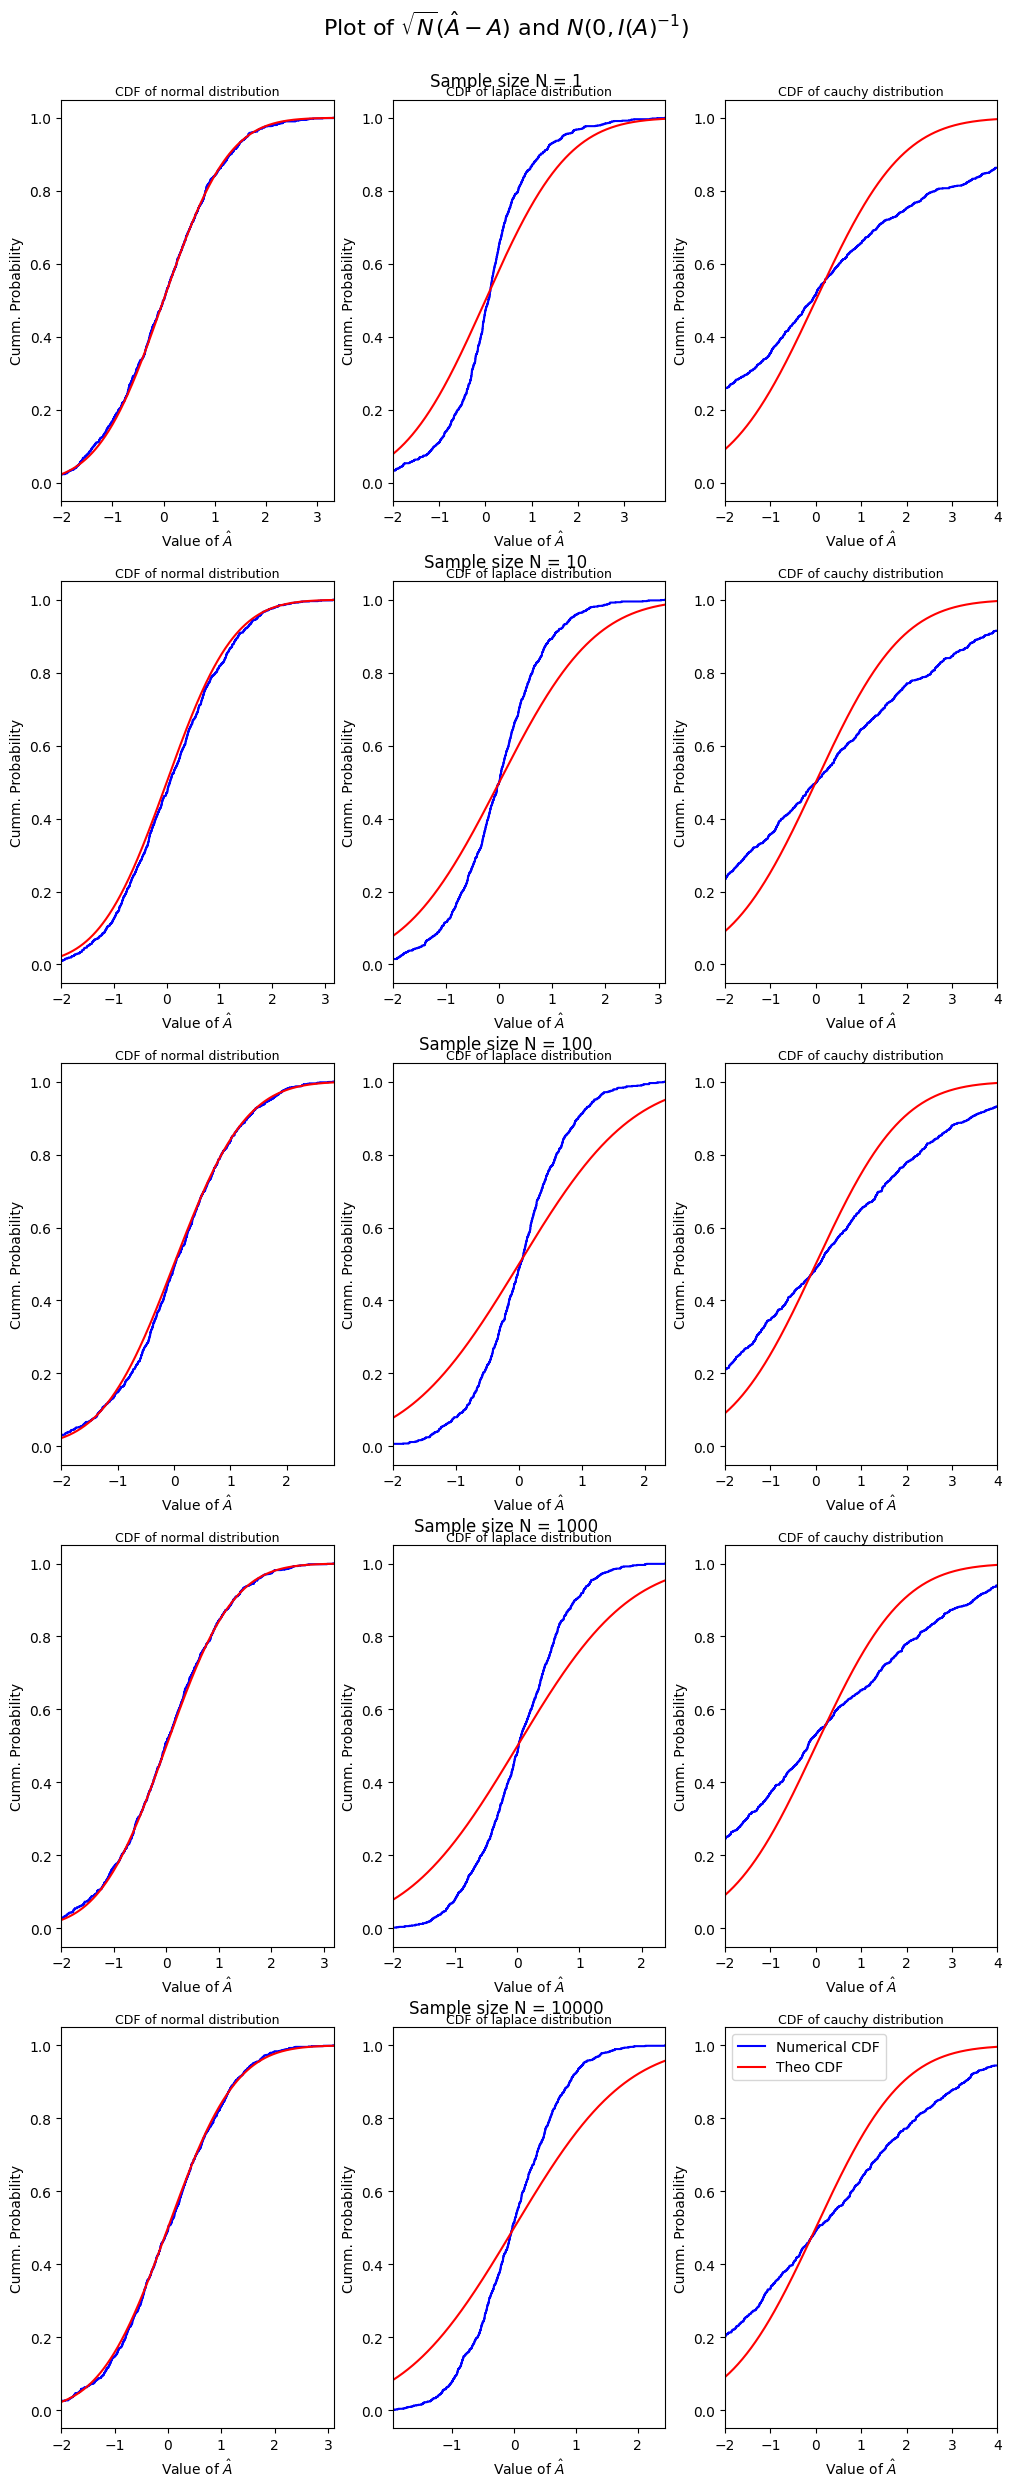

In [136]:
plot_cdf_I_a(n, 1, estimates1, stats1)

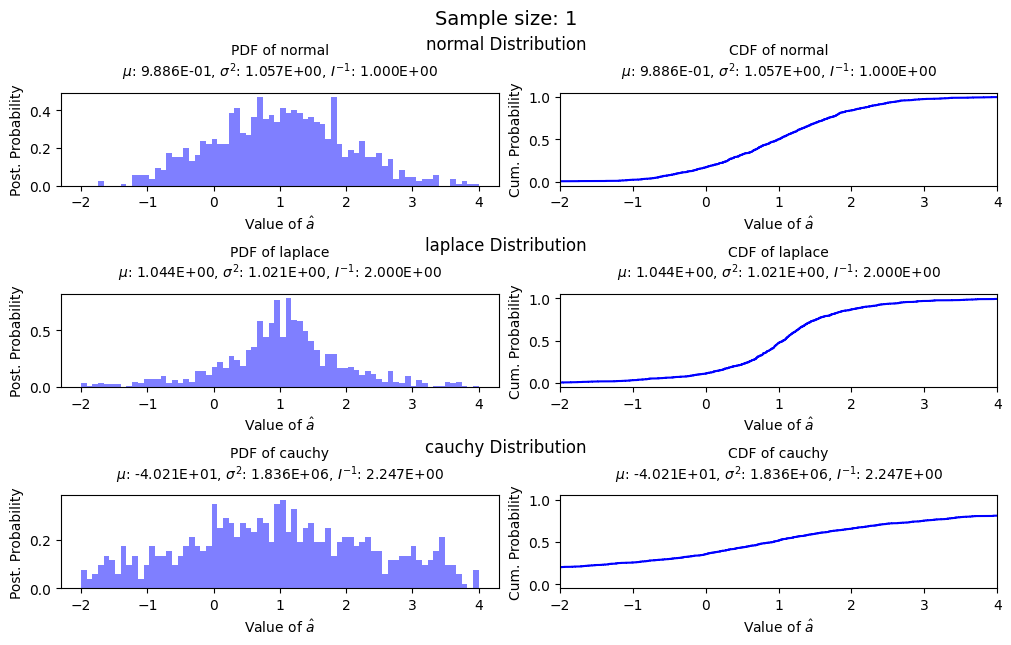

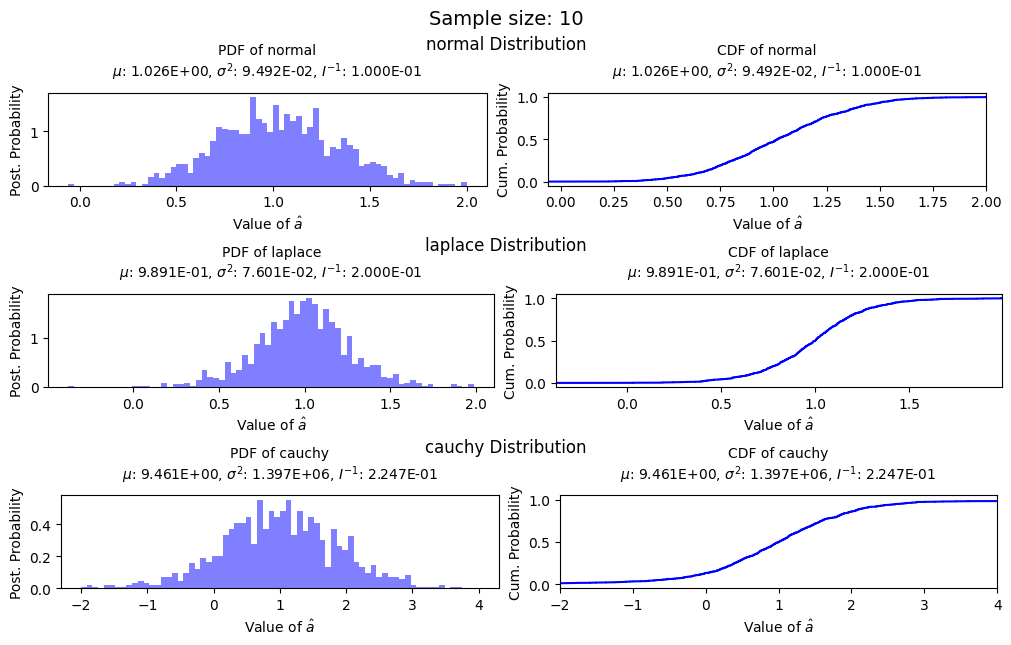

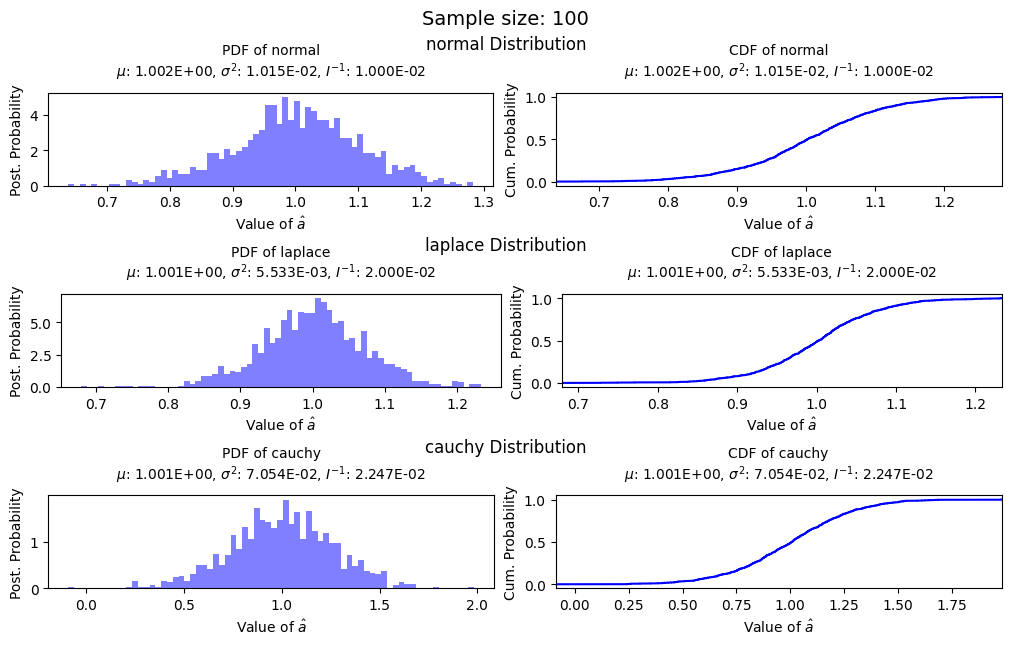

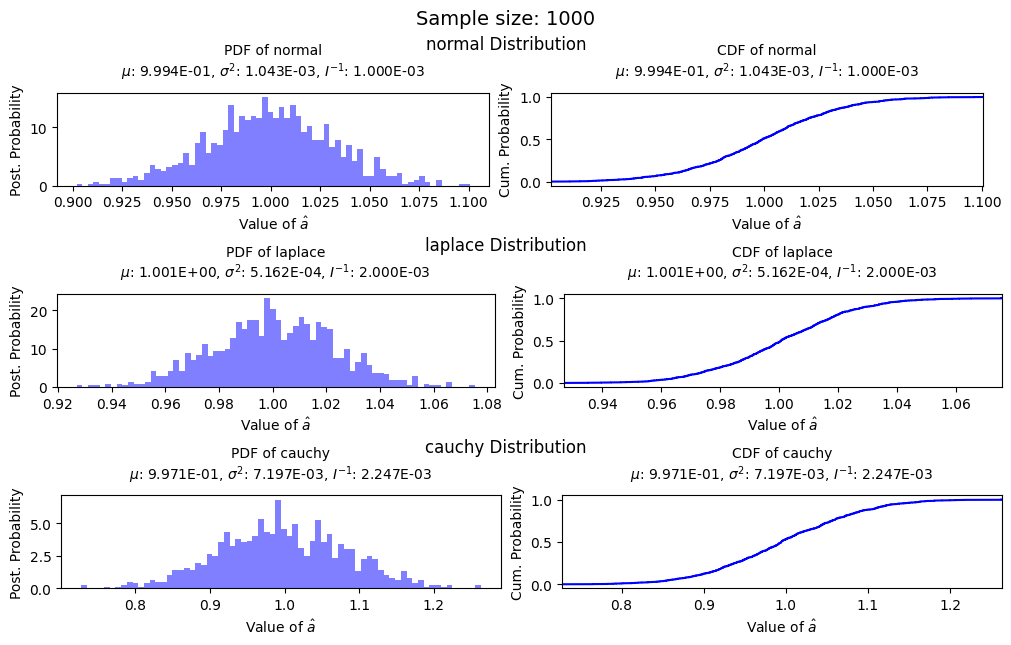

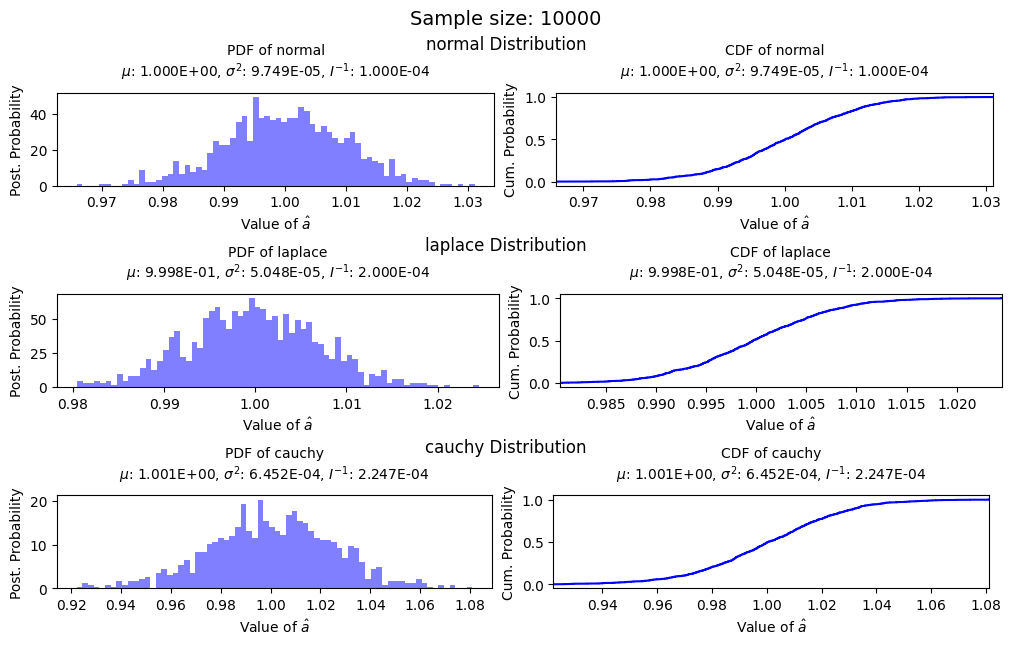

In [69]:
plot_cdf_pdf(n, 1, estimates1, stats1)

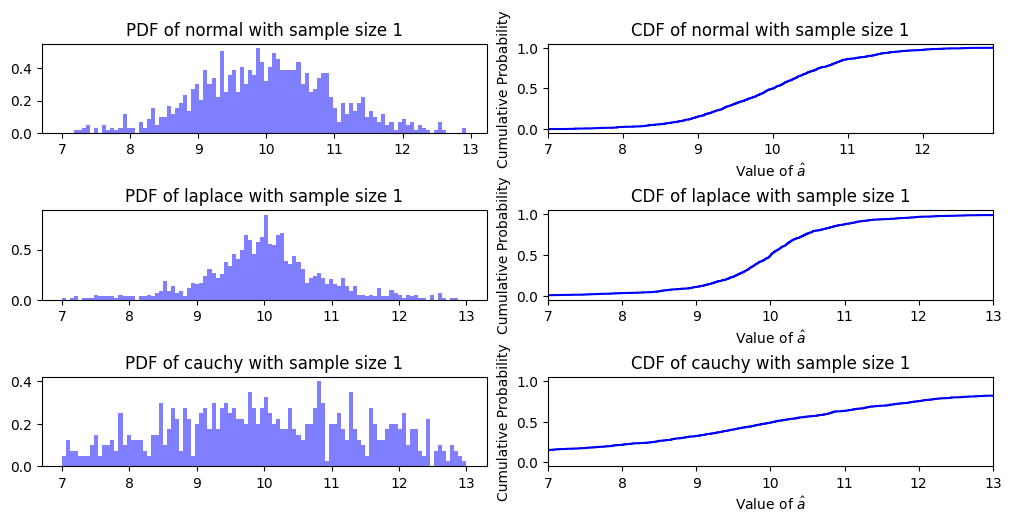

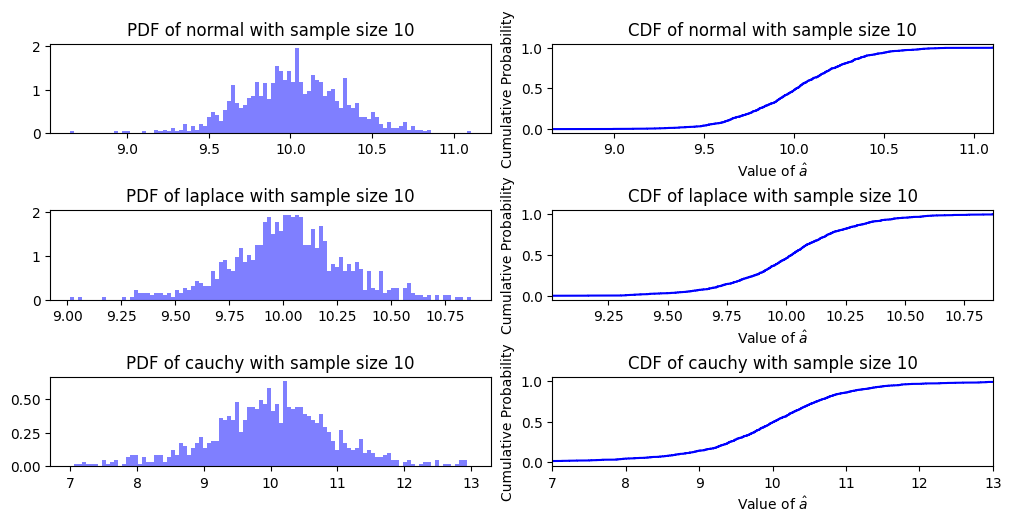

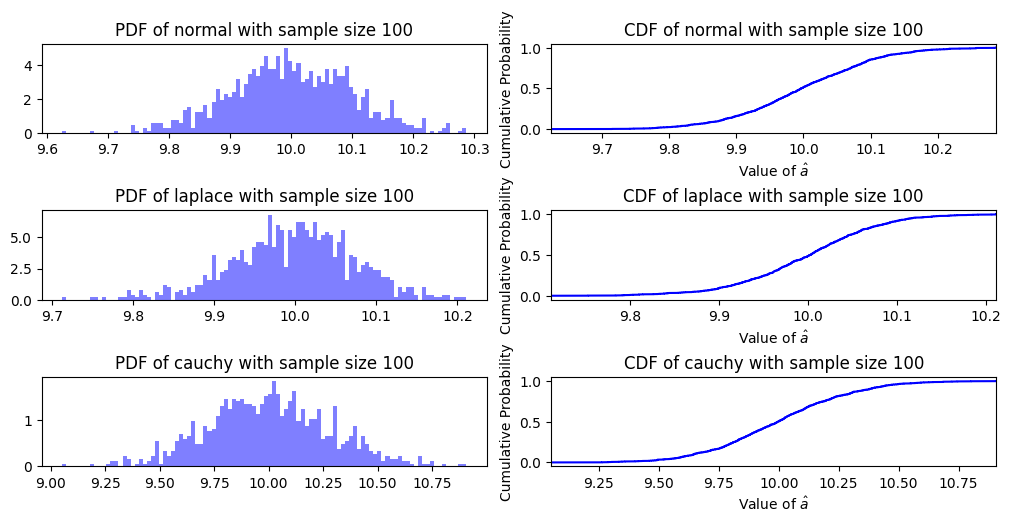

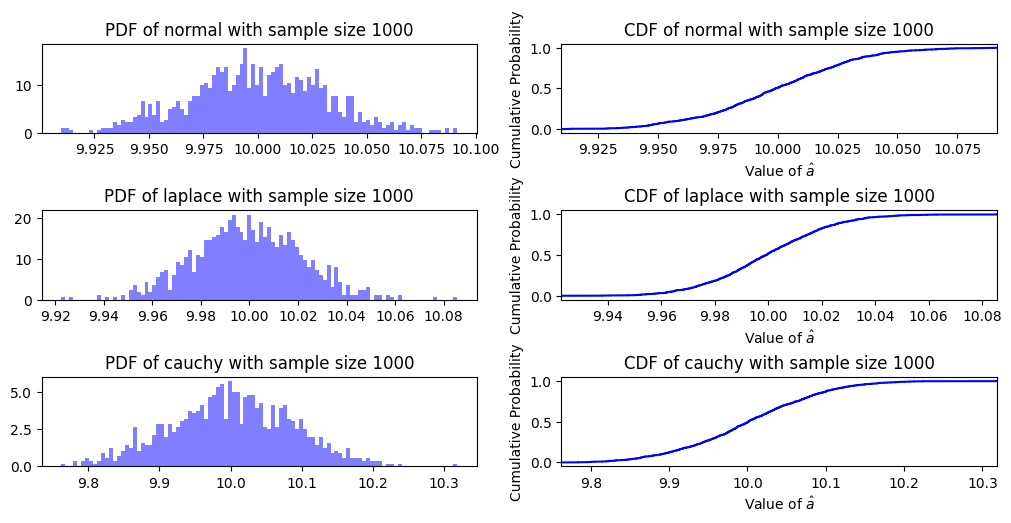

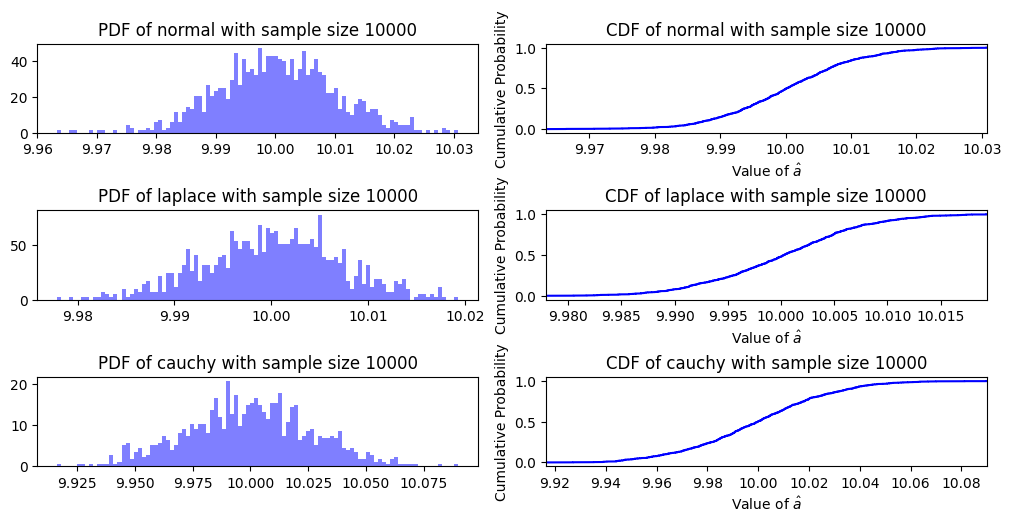

In [ ]:
plot_cdf_pdf(n, 10, estimates10, stats10)